In [ ]:
from __future__ import annotations
from scripts_for_plotting import *

In [ ]:
# CHANGE NEXT TWO LINES
configuration_file_location: str = "../input_files/tsfitpy_input_configuration_ba_oliver_y_nlte_fenlte.txt" # CHANGE
output_folder_location: str = "../output_files/Mar-27-2023-14-11-24_0.23697863971919042_y_nlte_fe_nlte_oliverba/" # CHANGE
# loads all data from config file and output
config_dict = load_output_data(configuration_file_location, output_folder_location)

In [ ]:
output_results_pd_df = config_dict["output_file_df"]   # Pandas dataframe for your own use
print("Column names are:")
print(output_results_pd_df.columns.values)             # Column names if you want to plot them
output_results_pd_df

In [ ]:
# can plot your own results using column names from the data frame
# can also take any extra arguments just like plt.scatter, example with color='black' is shown below
# can also add e.g. xlim=(-5, 5) or ylim=(-1, 1) for x and y limits
# CHANGE COLUMN NAMES IF NEEDED
plot_scatter_df_results(output_results_pd_df, "Fe_H", "chi_squared", color='black')
# works in similar way, but plots the density map with the desired cmap
# s=10 stands for point size
plot_density_df_results(output_results_pd_df, "Fe_H", "chi_squared", s=10, cmap="plasma_r", alpha=0.5)
# also histogram if needed as well
plot_histogram_df_results(output_results_pd_df, "Fe_H", color='grey', bins=20, alpha=0.5, histtype='bar', ec='black')

In [ ]:
# CHANGE NEXT LINE
star_name_to_plot: str = "302-600" # CHANGE
# plots all fitted lines for the requested star
plot_one_star(config_dict, star_name_to_plot)

12392537-3655409_spectrum.txt


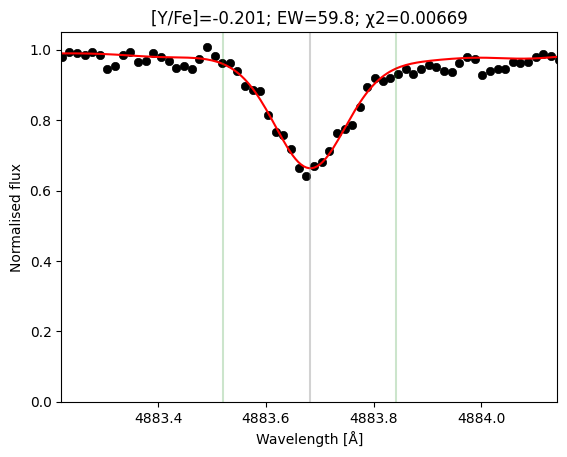

12433569-0554433_spectrum.txt


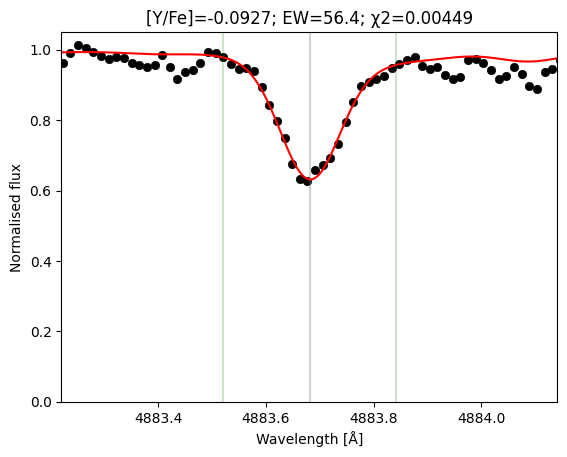

12560529-4514549_spectrum.txt


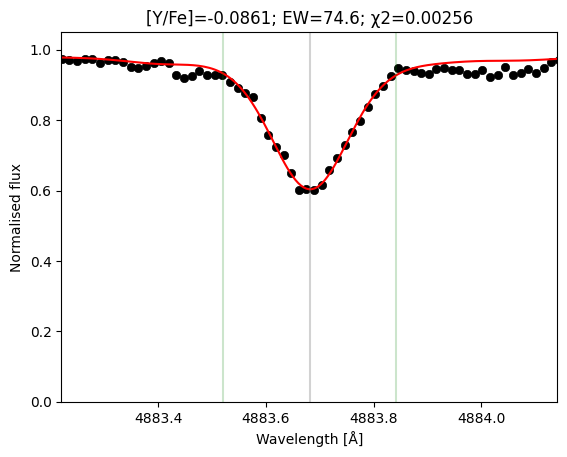

12562440-4518045_spectrum.txt


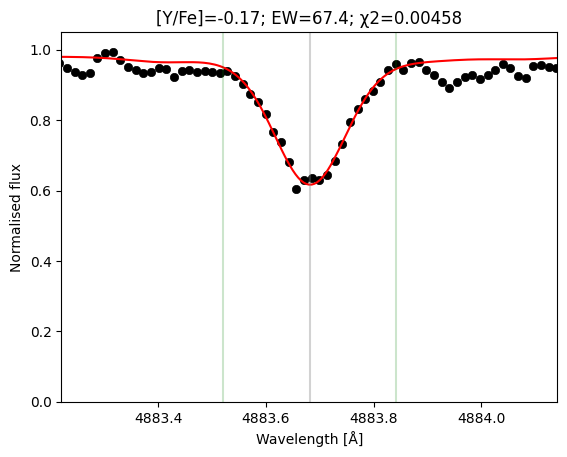

13011600-4101507_spectrum.txt


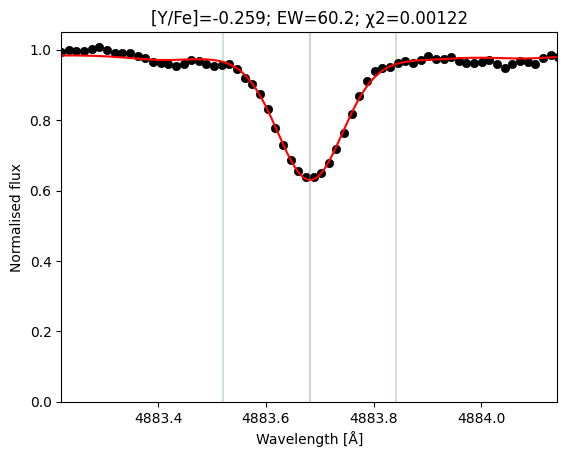

13140845-4601011_spectrum.txt


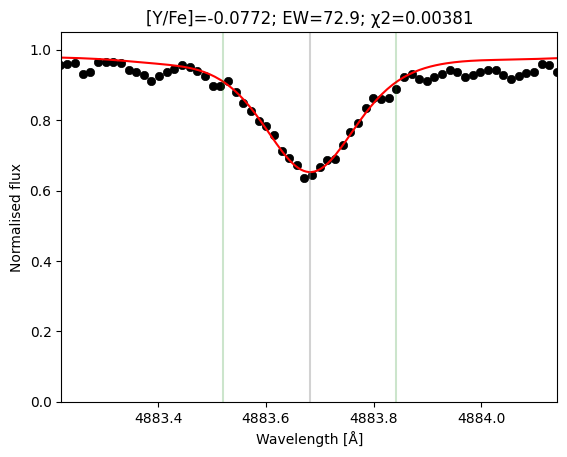

13142061-4554526_spectrum.txt


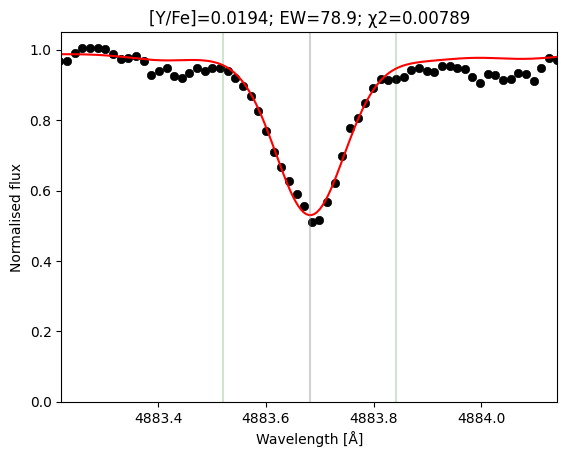

13203768-3659326_spectrum.txt


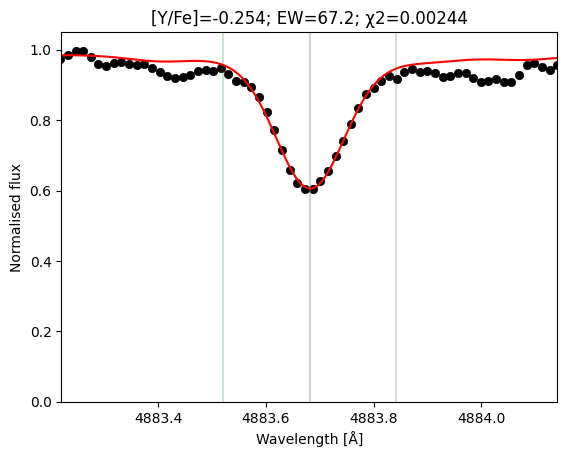

13395534-3412246_spectrum.txt


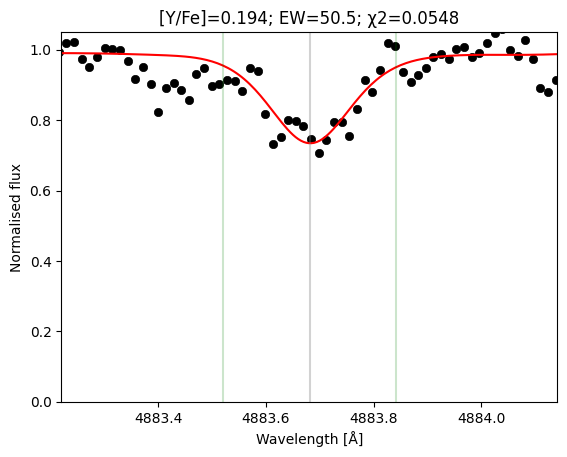

13434779-4055331_spectrum.txt


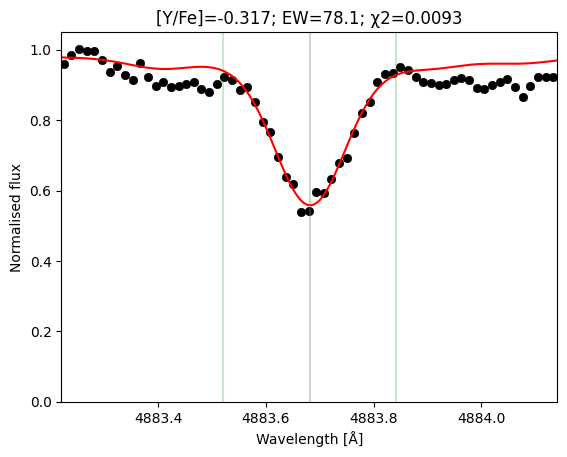

13491984-2013099_spectrum.txt


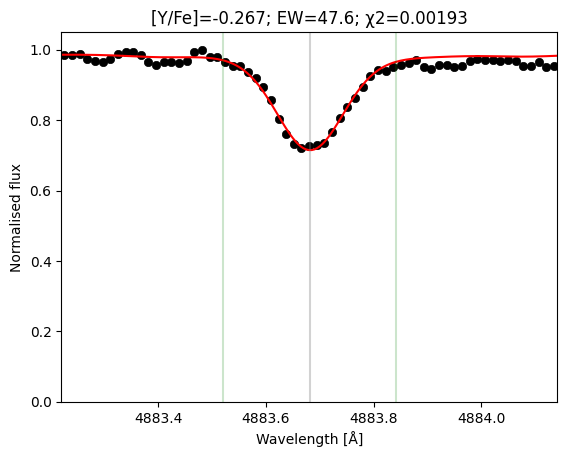

13593795-4234437_spectrum.txt


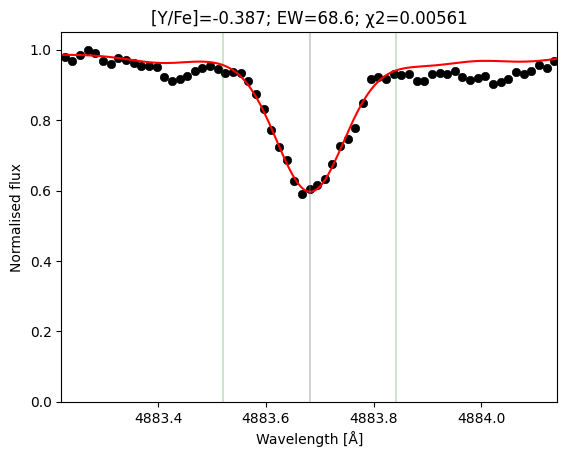

13595041-4231471_spectrum.txt


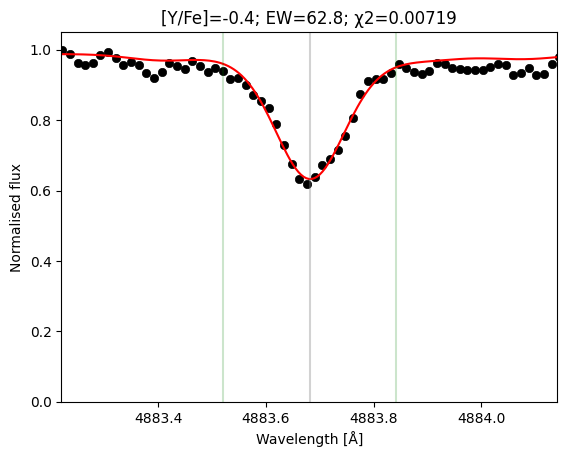

13595382-4459171_spectrum.txt


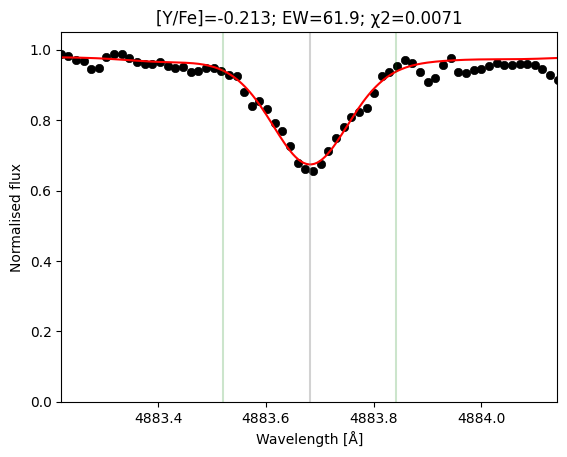

13595639-4054523_spectrum.txt


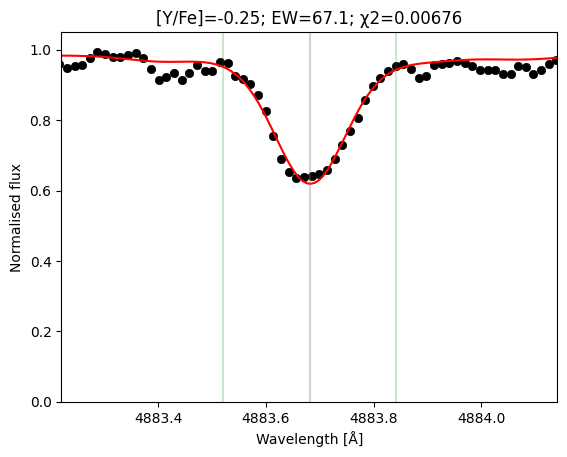

14000145-4221253_spectrum.txt


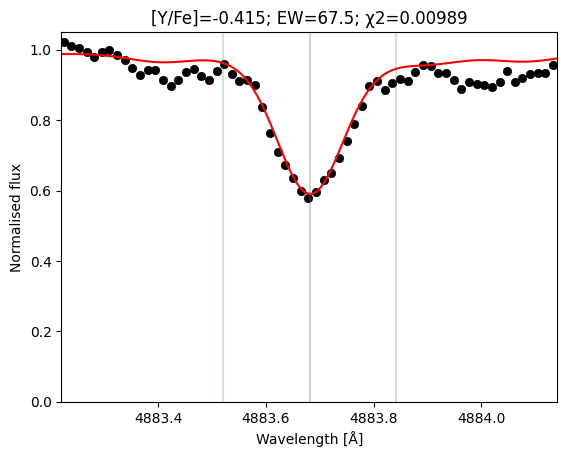

14002072-4224182_spectrum.txt


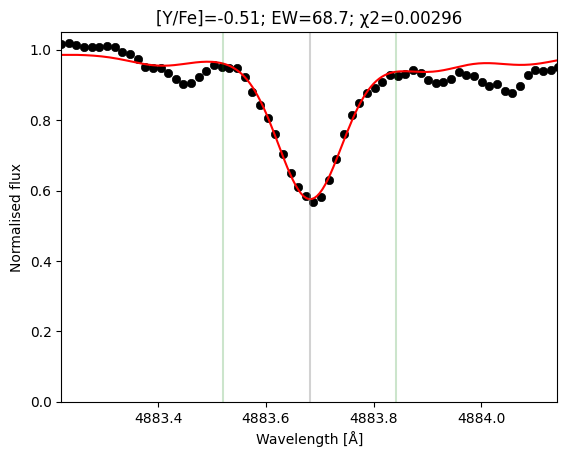

14002595-1003372_spectrum.txt


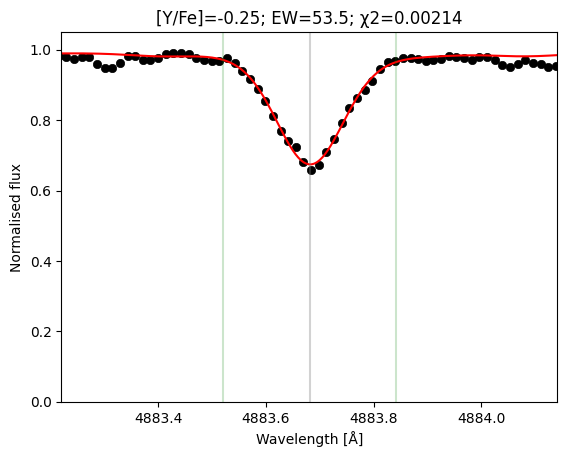

14003318-4054310_spectrum.txt


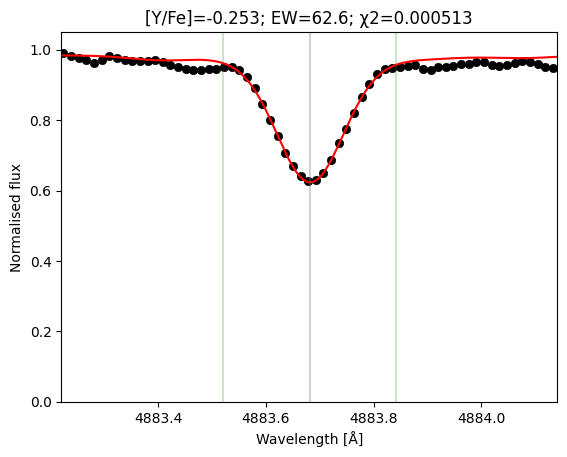

14095201-3402401_spectrum.txt


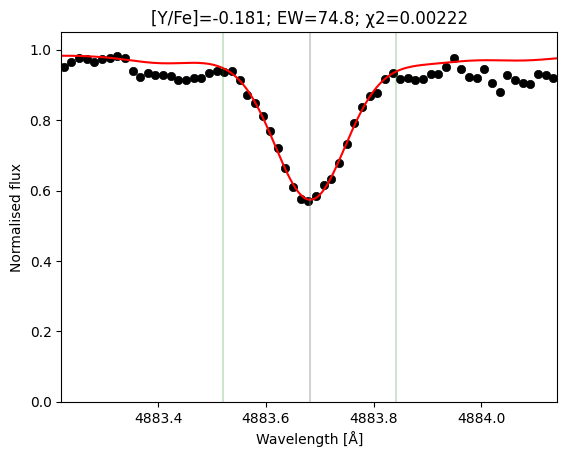

14192887-3353341_spectrum.txt


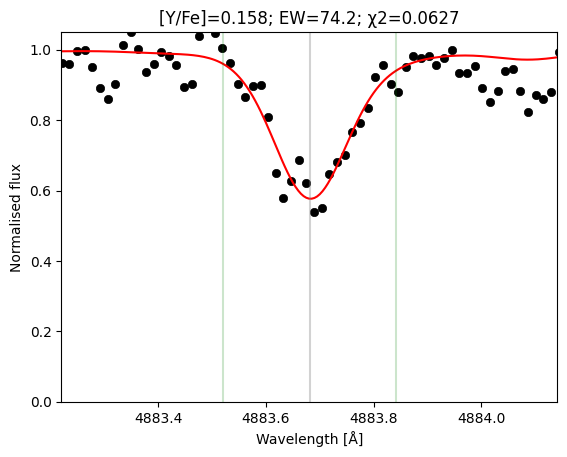

14193742-1956038_spectrum.txt


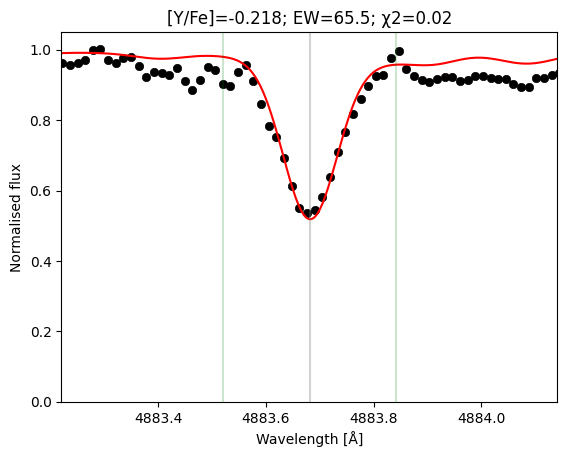

14194727-3357576_spectrum.txt


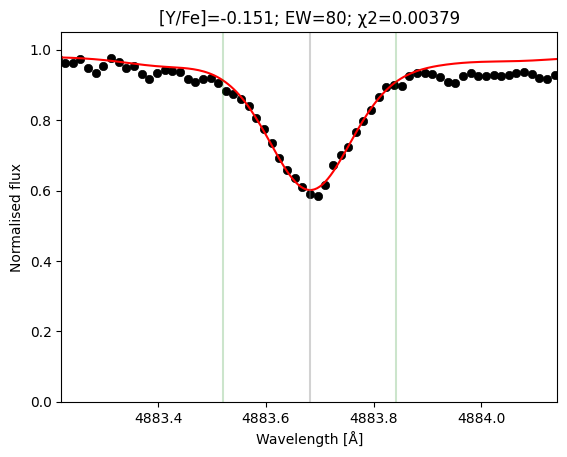

14194974-2000276_spectrum.txt


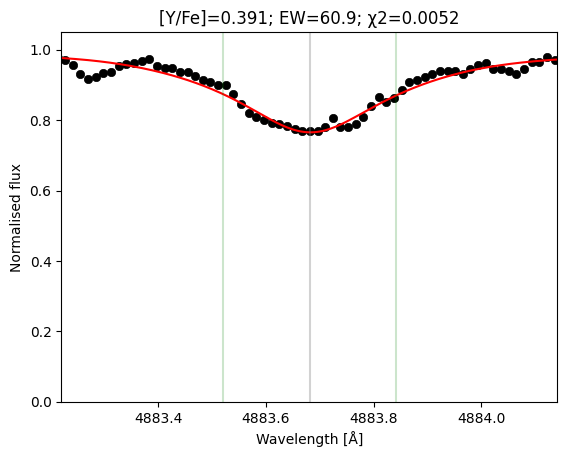

14212296-4407366_spectrum.txt


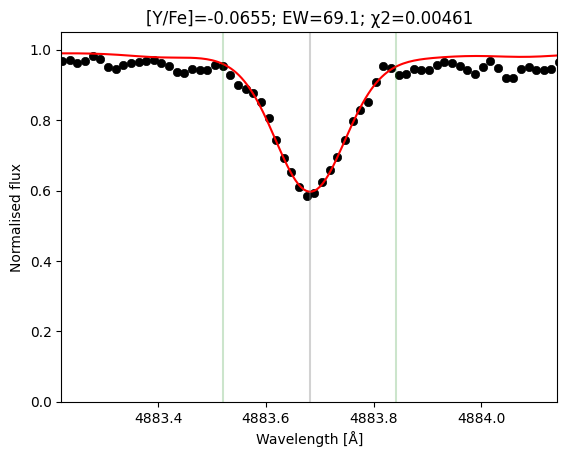

14393600-3703583_spectrum.txt


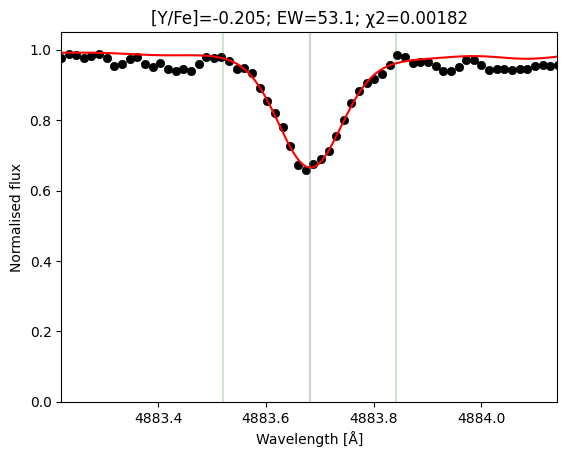

14395969-4056193_spectrum.txt


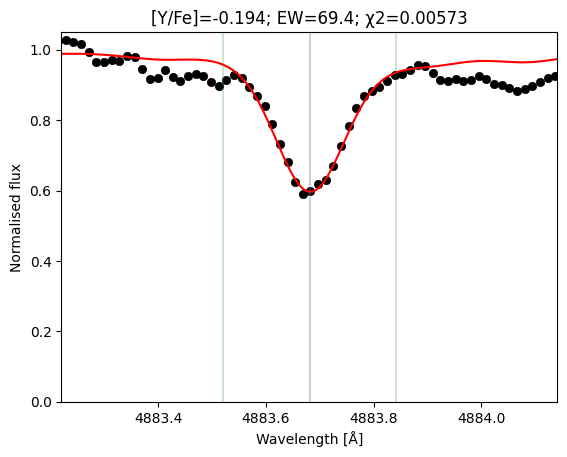

14401778-3703594_spectrum.txt


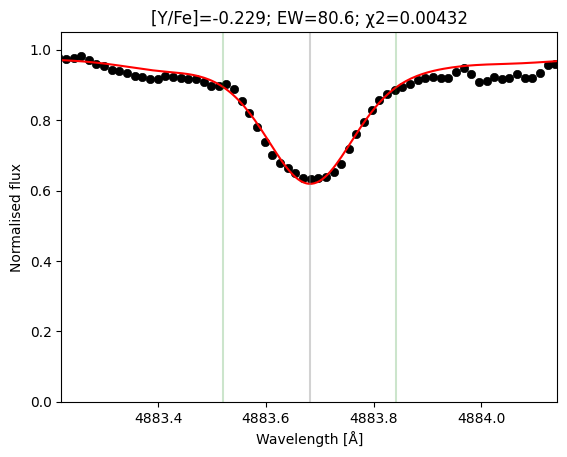

14402269-3657293_spectrum.txt


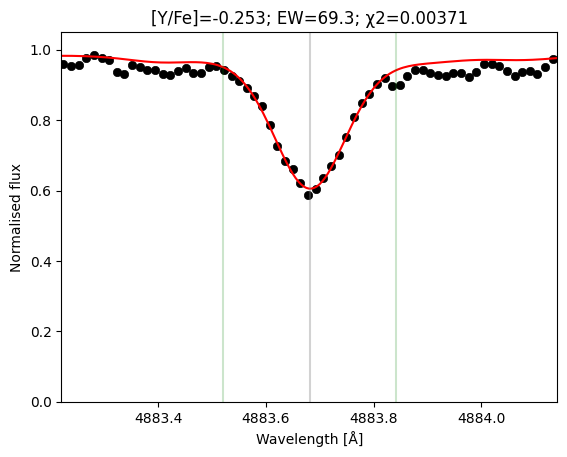

14402286-4105417_spectrum.txt


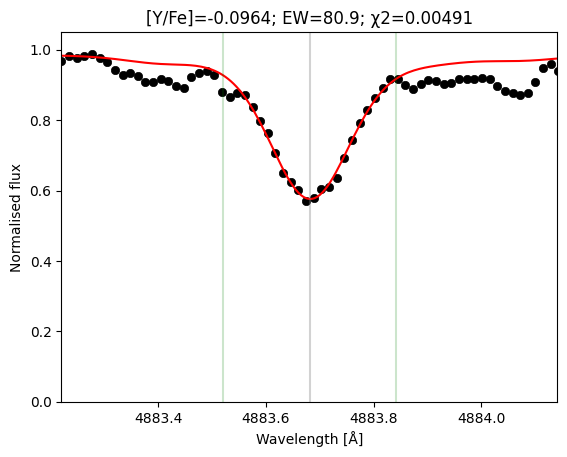

14405722-4004144_spectrum.txt


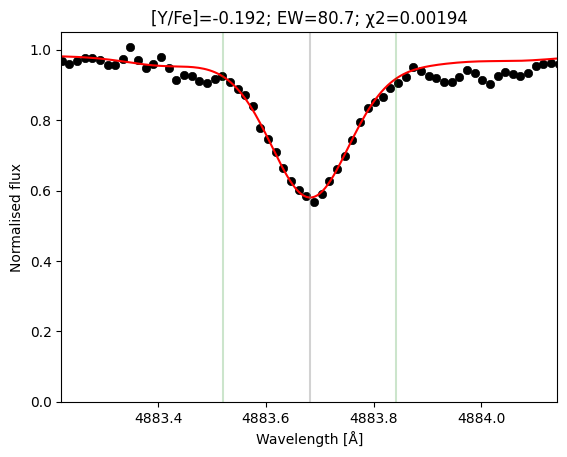

14495449-3402204_spectrum.txt


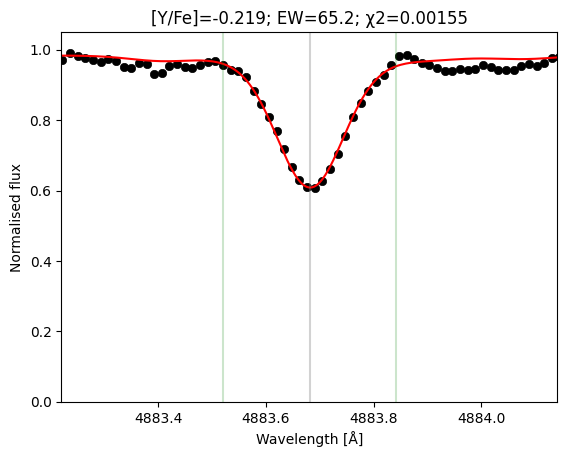

14501834-3405480_spectrum.txt


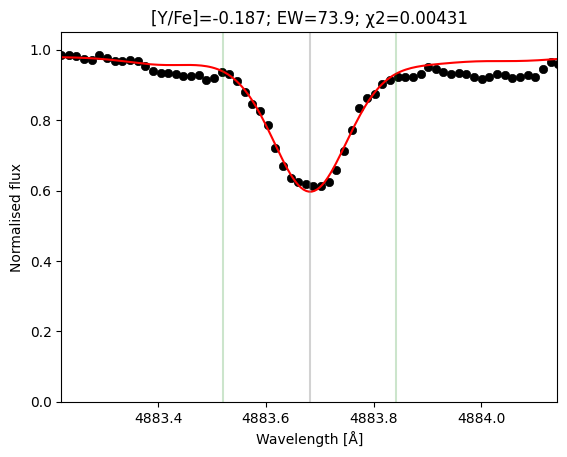

14505246-1959486_spectrum.txt


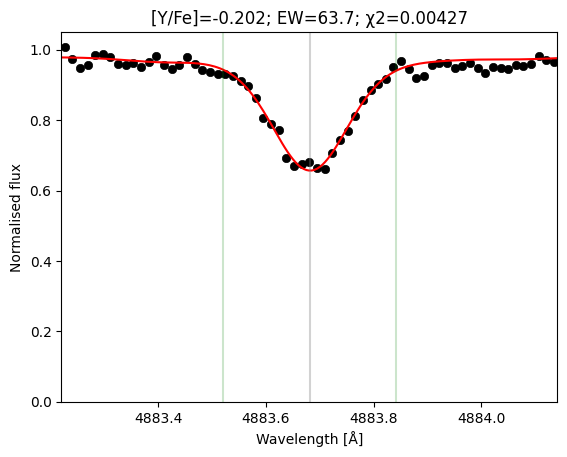

14590966-3958186_spectrum.txt


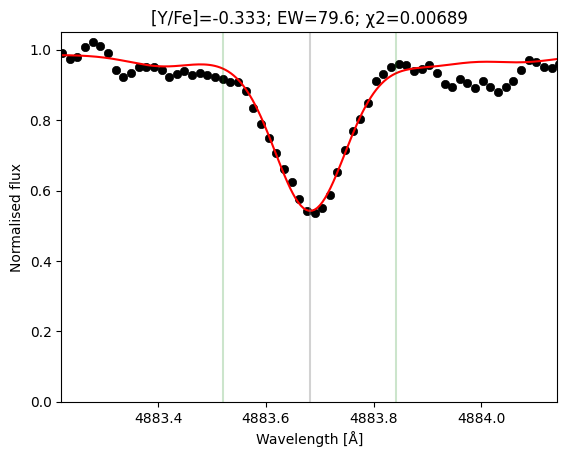

14595112-0504001_spectrum.txt


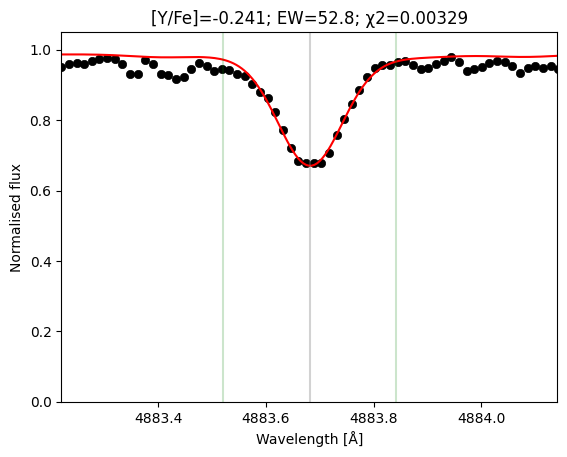

14595252-2001592_spectrum.txt


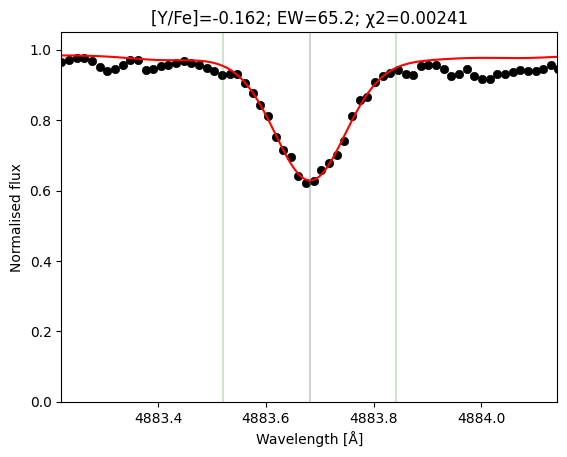

14595471-3401577_spectrum.txt


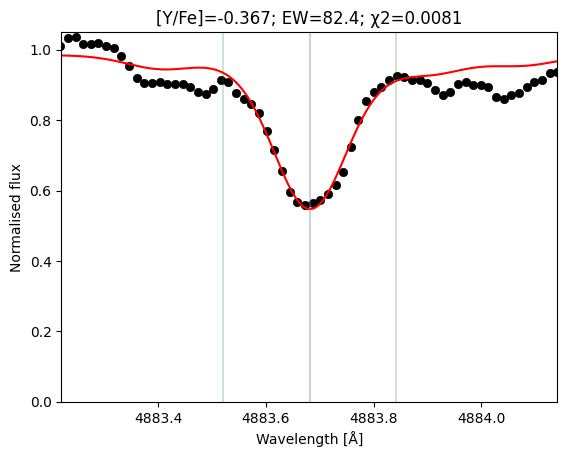

14595485-3654389_spectrum.txt


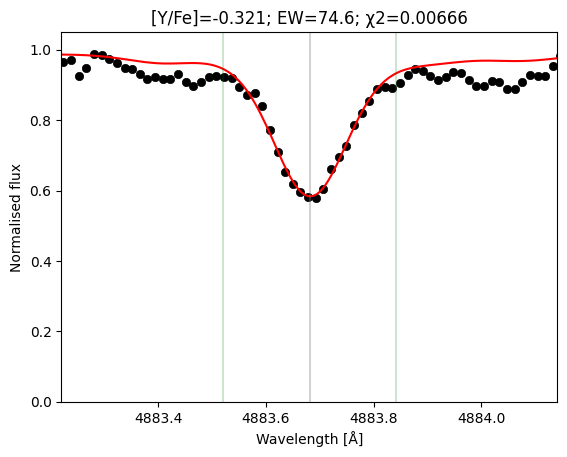

14595971-1955054_spectrum.txt


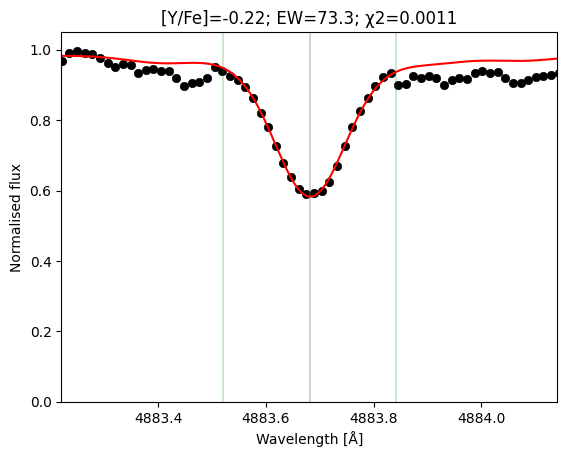

15000638-1503193_spectrum.txt


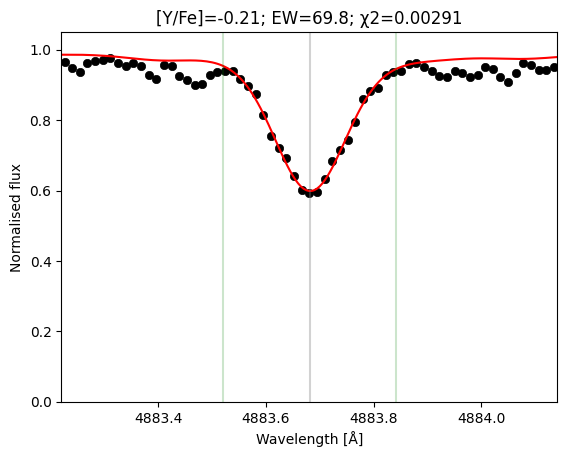

15002395-4006037_spectrum.txt


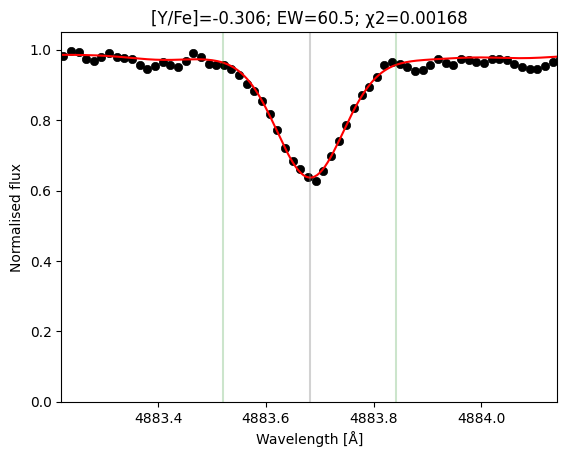

15002944-1955438_spectrum.txt


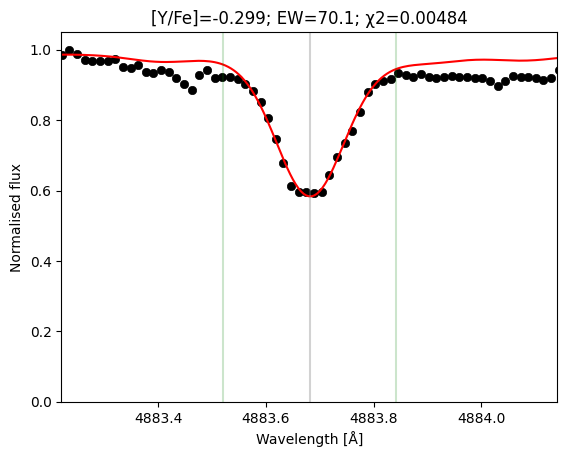

15050864-4003413_spectrum.txt


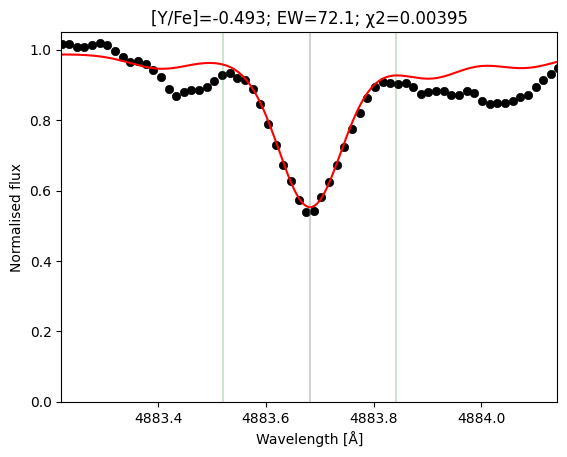

15053288-4000050_spectrum.txt


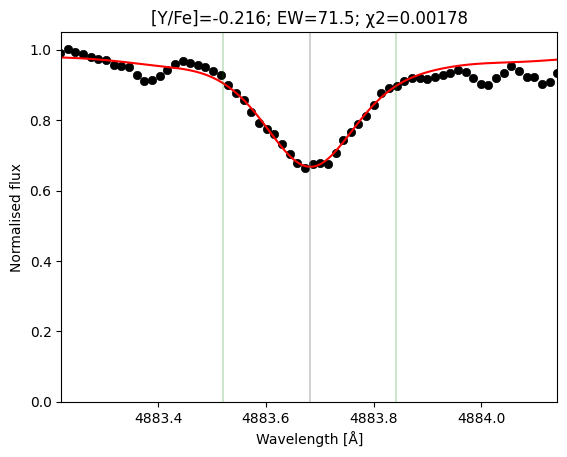

15101613-4003235_spectrum.txt


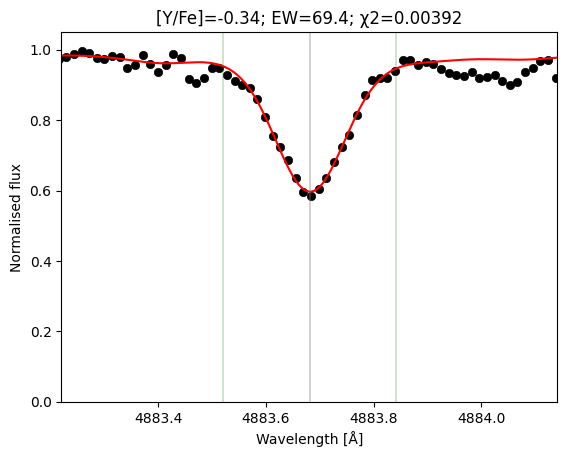

15103526-1952559_spectrum.txt


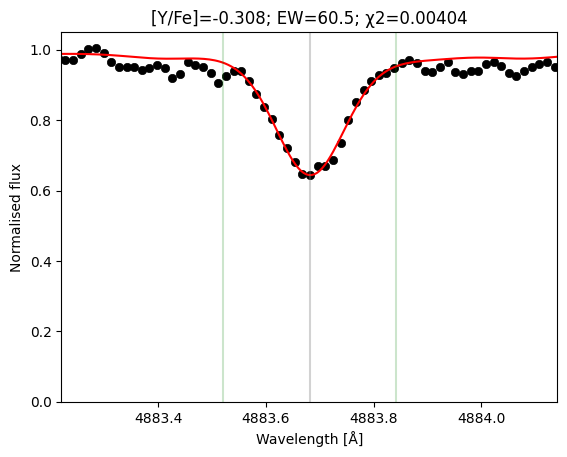

15170683-4131223_spectrum.txt


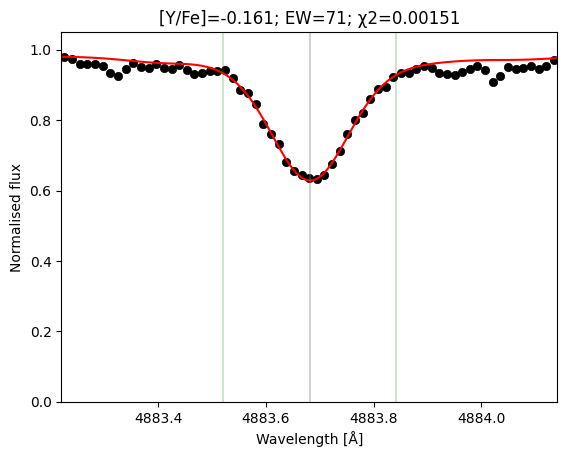

15195703-1957130_spectrum.txt


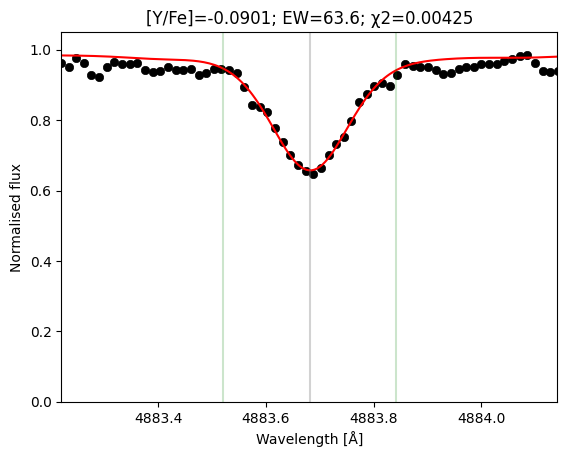

15195737-1950565_spectrum.txt


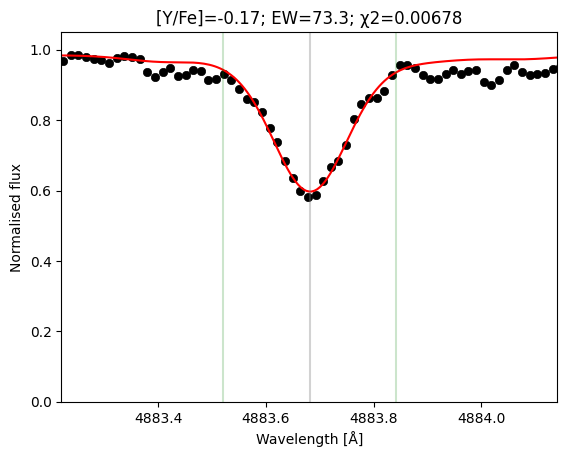

15200783-2004012_spectrum.txt


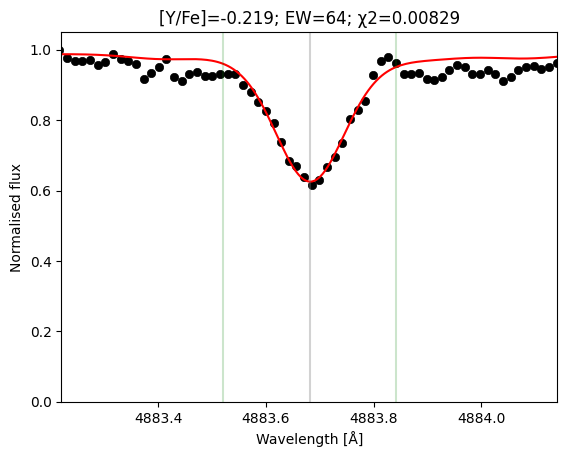

15230726-4221416_spectrum.txt


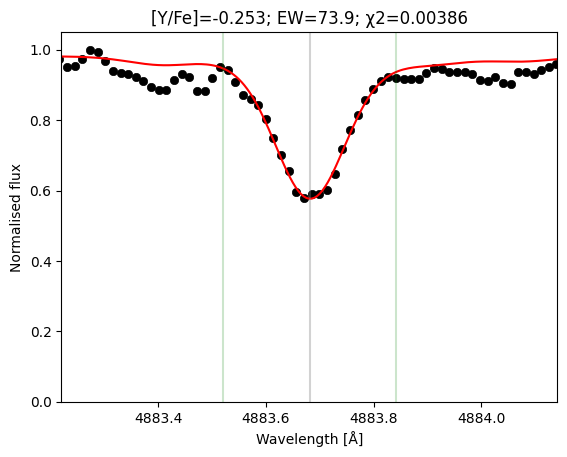

15292303-0956069_spectrum.txt


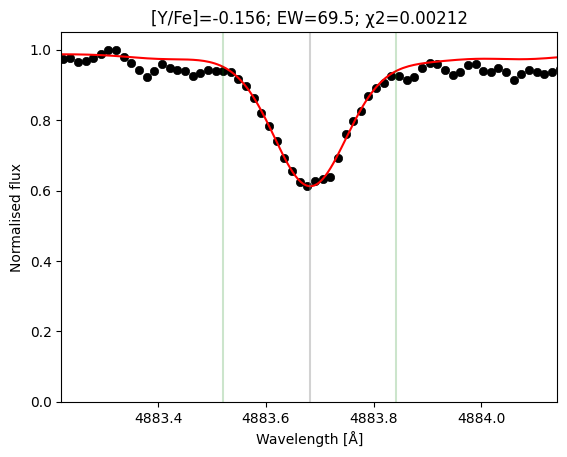

15294304-4257578_spectrum.txt


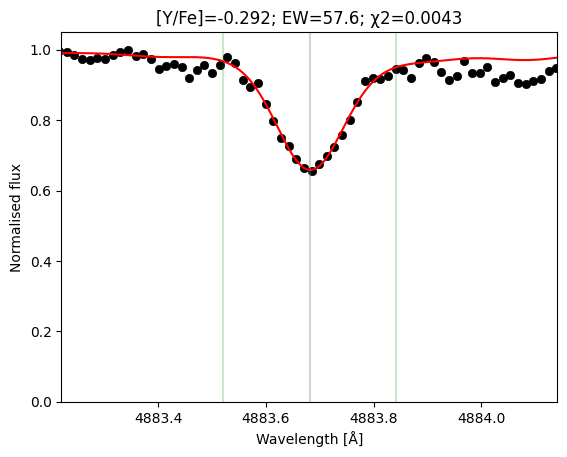

15303492-2003543_spectrum.txt


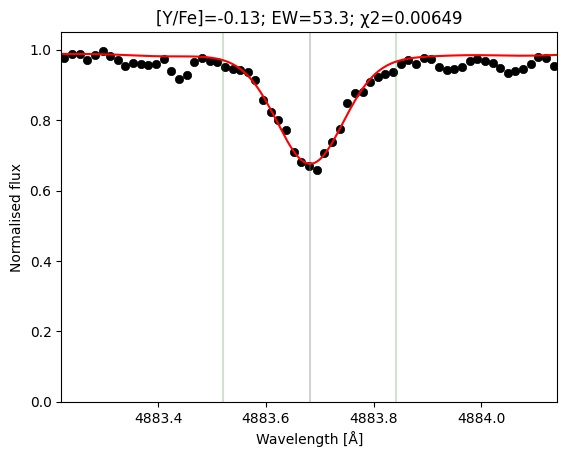

15532925-4059522_spectrum.txt


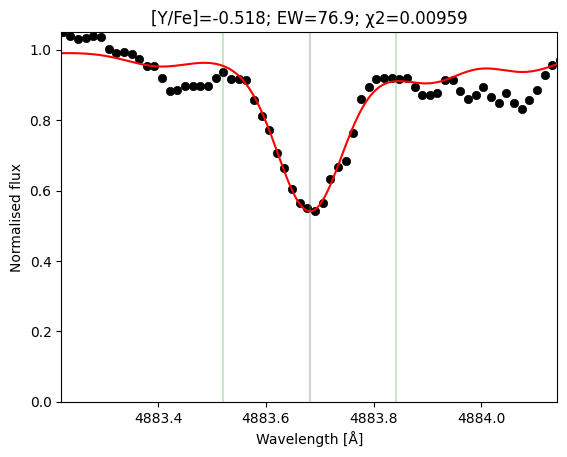

15534012-4055304_spectrum.txt


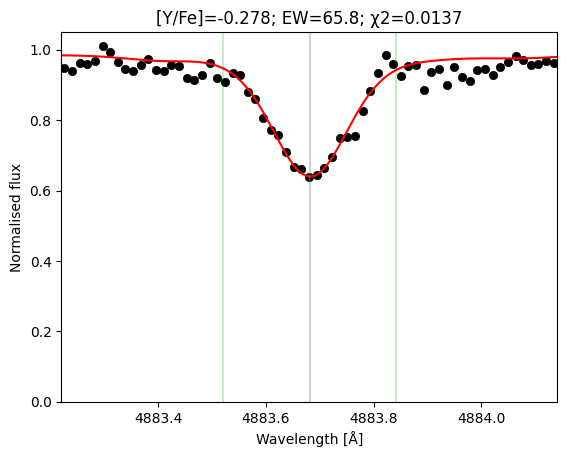

15535027-4105272_spectrum.txt


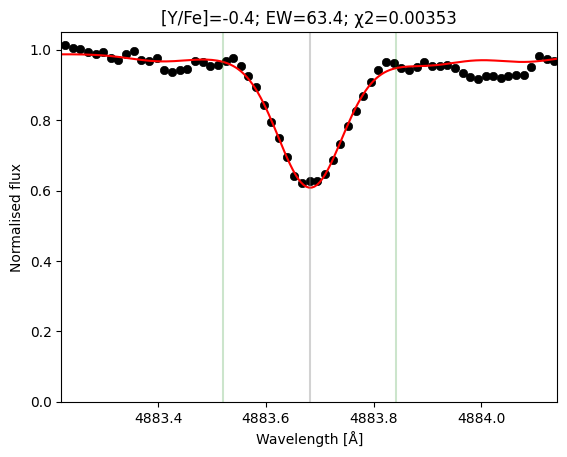

15540366-4052141_spectrum.txt


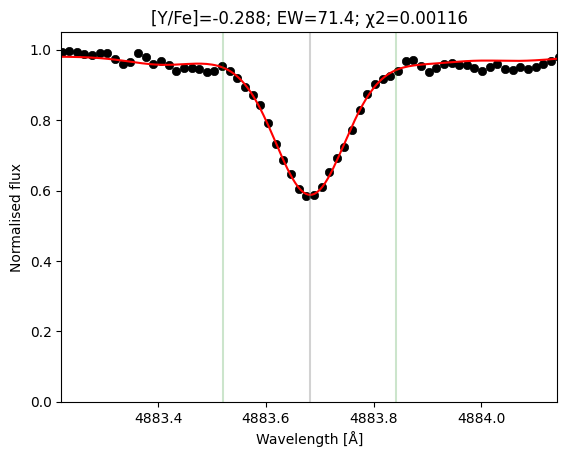

16595543-0503522_spectrum.txt


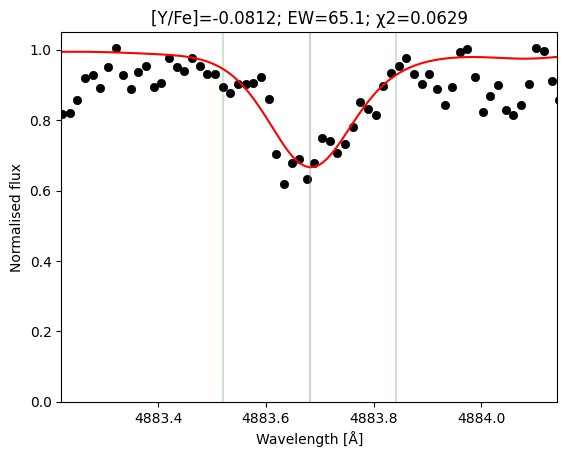

17345383-4300502_spectrum.txt


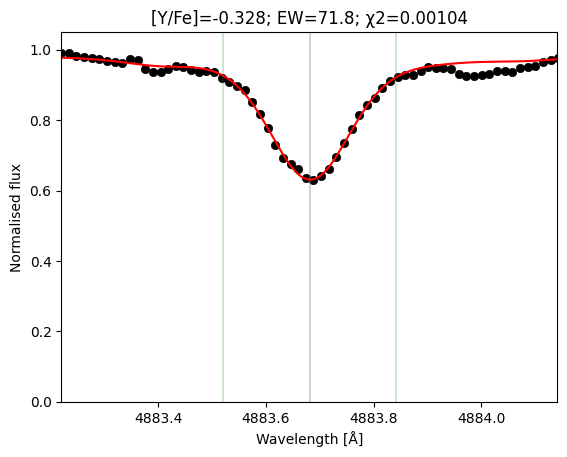

In [ ]:
# can also plot all stars and all lines as well
for specname in output_results_pd_df["specname"]:
    print(specname)
    plot_one_star(config_dict, specname)